In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import pyodbc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import normalize, MinMaxScaler

from sqlalchemy import create_engine
import urllib 

conn_string = r'Driver={ODBC Driver 13 for SQL Server};Server=PAUPC\SQL2017;Database=PerfmonDB;Trusted_Connection=yes;'
conn_parsed = urllib.parse.quote_plus(conn_string)
base_conn = "mssql+pyodbc:///?odbc_connect={}"

#engine = create_engine(base_conn.format(conn_parsed))

sql_conn = pyodbc.connect(conn_string)


In [2]:
#definir el campo a analizar y recargar datos
label = 'AvgLatchWaitTimems'

# ['AvgLockWaitTimems', 'AvgLatchWaitTimems', 'CPU_ProcessorTime', 'BatchRequests']

#leer de la tabla con los contadores de rendimiento
sql_query = "select * from PerfmonDB.dbo.vw_data_prepared_for_r_analysis_in_deep \
             where day = 26 and month = 10 and hour = 11"
                        #la hora donde tuvimos problemas"

#sql_query = "select * from PerfmonDB.dbo.vw_data_prepared_for_r_analysis_in_deep where \
#             month = 11 and day = 2 and hour = 11"                        

#leemos y nos quitamos columnas que sabemos que no nos van a aportar (0 SD o PK)
df_full = pd.read_sql(sql_query, sql_conn).drop(['sk_training', 'hour', 'minute', 'second', 
                                                 'year', 'day', 'month'], axis = 1)

# separar atributos y label
X = df_full.drop([label], axis = 1)
y = df_full[label]

print(df_full.shape)    
df_full.head(10)


(359, 52)


CPU_ProcessorTime  CPU_PrivilegedTime  CPU_InterruptTime  \
0               10.0                 2.0               0.02   
1               10.0                 3.0               0.01   
2               10.0                 2.0               0.04   
3               10.0                 2.0               0.03   
4                5.0                 2.0               0.02   
5               10.0                 2.0               0.02   
6               10.0                 2.0               0.01   
7               10.0                 2.0               0.02   
8                5.0                 2.0               0.02   
9               10.0                 2.0               0.03   

   ProcessorQueueLenght  BatchRequests  CompilationsSec  ActiveTempTables  \
0                   0.0         1842.0            422.0             216.0   
1                   0.0         3056.0            390.0             176.0   
2                   0.0         2942.0            464.0             202.0   
3                   0.0         3683.0            431.0             279.0   
4                   0.0         1347.0            391.0             176.0   
5                   0.0         1678.0            381.0             198.0   
6                   0.0         2637.0            376.0             211.0   
7                   0.0         2442.0            437.0             328.0   
8                   0.0         2286.0            312.0             185.0   
9                   0.0         3114.0            352.0             233.0   

   ActiveTransactions  TransactionsSec  WriteTransactionsSec  ...  \
0                 0.0              0.0                   0.0  ...   
1                 0.0              0.0                   0.0  ...   
2                 0.0              0.0                   0.0  ...   
3                 0.0              0.0                   0.0  ...   
4                 0.0              0.0                   0.0  ...   
5                 0.0              0.0                   0.0  ...   
6                 0.0              0.0                   0.0  ...   
7                 0.0              0.0                   0.0  ...   
8                 0.0              0.0                   0.0  ...   
9                 0.0              0.0                   0.0  ...   

   WorktablesCreatedSec  FreeSpaceScansSec  ForwardedRecordsSec  PageReadsSec  \
0                 216.0              186.0                  0.0         174.0   
1                 176.0              234.0                  0.0         242.0   
2                 202.0              203.0                  0.0         154.0   
3                 279.0              150.0                  0.0         153.0   
4                 176.0              180.0                  0.0         124.0   
5                 198.0              207.0                  0.0         289.0   
6                 211.0              171.0                  0.0         327.0   
7                 328.0              446.0                  0.0         519.0   
8                 185.0              179.0                  0.0          99.0   
9                 233.0              208.0                  0.0         233.0   

   PageLifeExpectancySec  PageLookupsSec  PageWritesSec  LoginsSec  \
0                 7901.0        815929.0         1002.0       91.0   
1                 7901.0       1057610.0         1832.0       59.0   
2                 7901.0        789727.0         1066.0      114.0   
3                 7901.0        521481.0            5.0       81.0   
4                 7901.0        688034.0            0.0       76.0   
5                 7901.0        969234.0           22.0       72.0   
6                10858.0        600657.0          263.0       67.0   
7                10858.0        501386.0            0.0       80.0   
8                10858.0        544058.0            0.0       60.0   
9                10645.0        670023.0          502.0       62.0   

   LogoutsSec  ContextSwitchesSec  
0 

[Text(0.5, 0, 'CPU_ProcessorTime'),
 Text(1.5, 0, 'CPU_PrivilegedTime'),
 Text(2.5, 0, 'CPU_InterruptTime'),
 Text(3.5, 0, 'ProcessorQueueLenght'),
 Text(4.5, 0, 'BatchRequests'),
 Text(5.5, 0, 'CompilationsSec'),
 Text(6.5, 0, 'ActiveTempTables'),
 Text(7.5, 0, 'ActiveTransactions'),
 Text(8.5, 0, 'TransactionsSec'),
 Text(9.5, 0, 'WriteTransactionsSec'),
 Text(10.5, 0, 'AvgLatchWaitTimems'),
 Text(11.5, 0, 'AvgLockWaitTimems'),
 Text(12.5, 0, 'BufferCacheHitRatio'),
 Text(13.5, 0, 'PlanCache_CacheHitRatio_Total'),
 Text(14.5, 0, 'PlanCache_CacheHitRatio_SQLPlans'),
 Text(15.5, 0, 'PlanCache_CacheHitRatio_ObjectPlans'),
 Text(16.5, 0, 'PlanCache_CacheHitRatio_TempTables'),
 Text(17.5, 0, 'PlanCache_CacheHitRatio_BoundTrees'),
 Text(18.5, 0, 'CurrentDiskQueueLength'),
 Text(19.5, 0, 'DiskReadBytesSec'),
 Text(20.5, 0, 'DiskReadsSec'),
 Text(21.5, 0, 'DiskTransfersSec'),
 Text(22.5, 0, 'DiskWriteBytesSec'),
 Text(23.5, 0, 'DiskWritesSec'),
 Text(24.5, 0, 'PhysicalDiskIdleTime'),
 Text(2

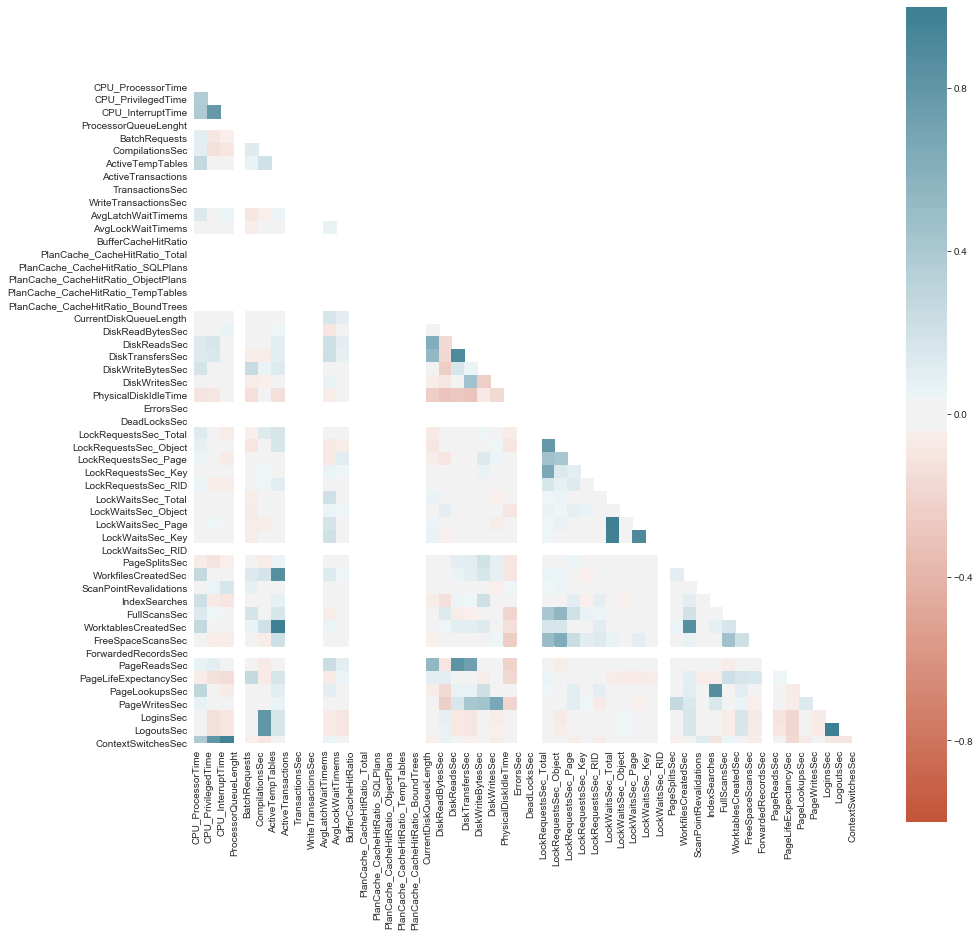

In [3]:
#vamos a ver las correlaciones básicas 
corr = df_full.corr()

sns.set_style("whitegrid")
plt.figure(figsize = (15, 15))

#creamos una mascara para evitar la diagonal superior
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, 
    mask = mask
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)


## Exploración de un correlation plot
Los gráficos de correlación son muy útiles y podemos empezar a ver elementos significativos (correlaciones altas entre métricas de CPU y ContextSwitches, por ejemplo, pero ahondaremos más adelante en eso). 

Sin embargo, cuando el dataset tiene una alta dimensionalidad, podemos tener problemas para visualizar éste tipo de gráficos como matrices o dendogramas de nulos, por ejemplo 

In [4]:

param_grid = {
    "num_leaves": list(range(10, 500, 10)),
    "max_depth": list(range(20, 300, 10)),
    "reg_alpha": list(np.arange(0.1, 1.1, 0.1)),
    "reg_lambda": list(np.arange(0.1, 1.1, 0.1)),
    #mas cerca de valores bajos, distribucion logaritmica
    "learning_rate":  [float(elems) for elems in list(np.logspace(np.log(0.01), np.log(0.3), base = np.exp(1), num = 20))],
    "n_estimators": [int(elems) for elems in list(np.logspace(np.log(800), np.log(3000), base = np.exp(1), num = 30))]
}


In [5]:
lgb_regressor = lgb.LGBMRegressor()

n_iters = 5

#establecemos un buscador aleatorio de hiperparametros en el grid que hemos definido anteriormente
random_search = RandomizedSearchCV(estimator = lgb_regressor, param_distributions = param_grid, 
                                   n_iter = n_iters, scoring = 'r2', cv = 3, verbose = 2)


In [6]:
#buscar la mejor combinación de hiperparametros
print('prediciendo para ' + label)
random_search.fit(X = X, y = y.ravel())


prediciendo para AvgLatchWaitTimems
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] reg_lambda=0.9, reg_alpha=1.0, num_leaves=30, n_estimators=2500, max_depth=110, learning_rate=0.059900747134842926 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  reg_lambda=0.9, reg_alpha=1.0, num_leaves=30, n_estimators=2500, max_depth=110, learning_rate=0.059900747134842926, total=   1.3s
[CV] reg_lambda=0.9, reg_alpha=1.0, num_leaves=30, n_estimators=2500, max_depth=110, learning_rate=0.059900747134842926 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[CV]  reg_lambda=0.9, reg_alpha=1.0, num_leaves=30, n_estimators=2500, max_depth=110, learning_rate=0.059900747134842926, total=   1.1s
[CV] reg_lambda=0.9, reg_alpha=1.0, num_leaves=30, n_estimators=2500, max_depth=110, learning_rate=0.059900747134842926 
[CV]  reg_lambda=0.9, reg_alpha=1.0, num_leaves=30, n_estimators=2500, max_depth=110, learning_rate=0.059900

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...
                                                       120, 130, 140, 150, 160,
                                                       1

In [7]:
model = random_search.best_estimator_
print("best r2: " + str(random_search.best_score_))
#print("params: " + str(random_search.best_params_))

random_search.best_params_


best r2: -0.3266583063711121


{'reg_lambda': 1.0,
 'reg_alpha': 0.9,
 'num_leaves': 200,
 'n_estimators': 1736,
 'max_depth': 290,
 'learning_rate': 0.020463169223314863}

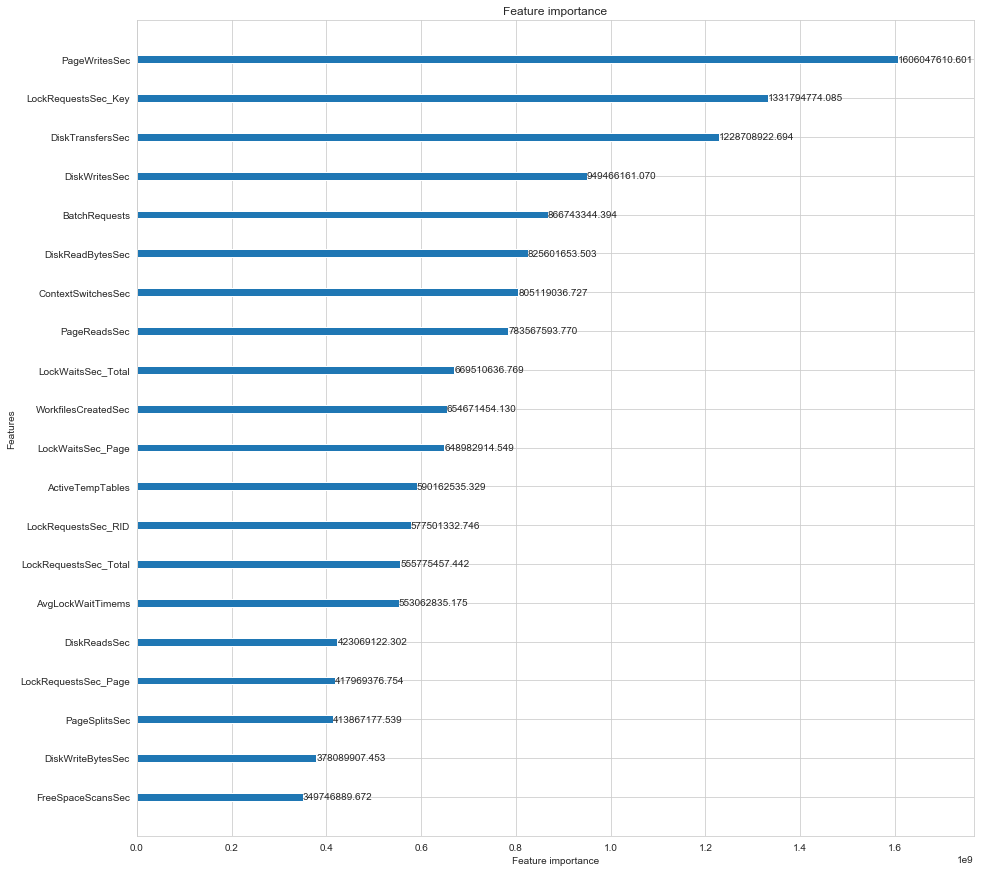

In [8]:
#plotting styles
sns.set_style("whitegrid")

#mostrar la importancia de variables basado en gain y no en numero de splits
lgb.plot_importance(model, importance_type='gain', max_num_features=20, figsize=(15, 15))


## Claves de análisis 
Context switches por segundo aparece en 5o lugar en la importancia de variables. Esto es muy significativo porque no debería hacerlo, no es habitual que actividad que no sea de disco (como sí son el resto de contadores) tenga tanta influencia en las esperas por latches! 

El resto de indicadores sí podrían ser normales, pero aquí tenemos la clave de que hay que modificar configuraciones de CPU. En este caso, comprar más licencias para más cores en la máquina física.

In [10]:
import shap 

shap.initjs()

explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(X)


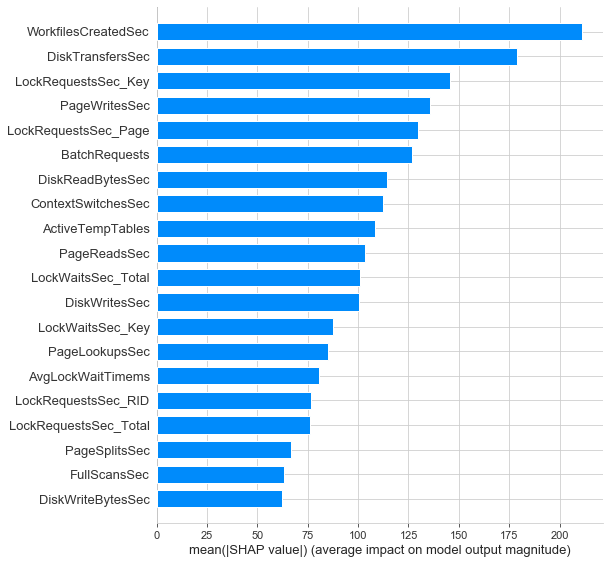

In [11]:
shap.summary_plot(
                    shap_values=shap_values, features = X, max_display = 20, 
                    feature_names=X.columns, plot_type='bar'
                 )

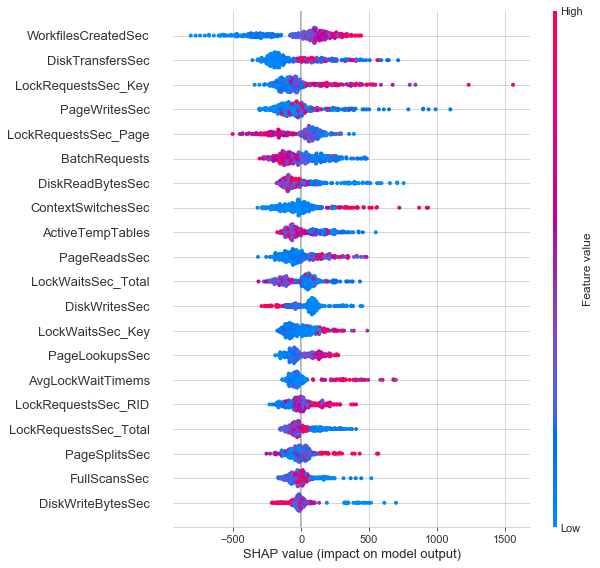

In [12]:
sns.set_style("whitegrid")
shap.summary_plot(
                  shap_values=shap_values, features = X, max_display = 20, 
                  feature_names=X.columns)

In [13]:
# los plots de dependencia para las columnas más interesantes son incluso más detallados
# para analizar las interacciones entre variables
columns = [
            'ContextSwitchesSec', 
            #'AvgLatchWaitTimems', 
            'PageLifeExpectancySec', 
            'IndexSearches',
            'PageLookupsSec'
          ]


In [14]:
import matplotlib.dates as mdates 
locator = mdates.HourLocator
locator.MAXTICKS = 10000
ax.set_axes_locator(locator = locator)
sns.set_style("whitegrid")


## Análisis de dependance plots
Vamos a analizar las interacciones entre features de muestra. Este análisis debería ser más detallado y dirigido a aquellas que creemos que pueden determinar las acciones a tomar a futuro para nuestro negocio

printing feature: ContextSwitchesSec against PageLifeExpectancySec


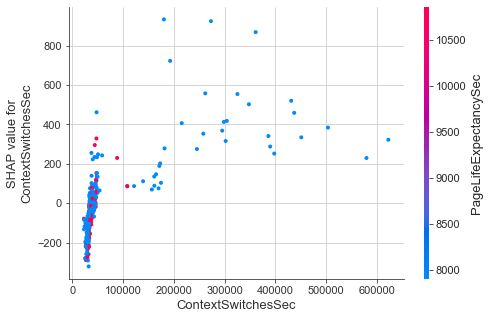

printing feature: ContextSwitchesSec against IndexSearches


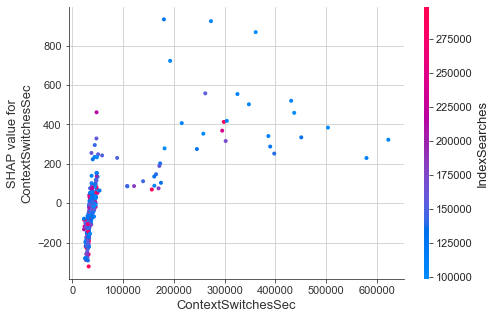

printing feature: ContextSwitchesSec against PageLookupsSec


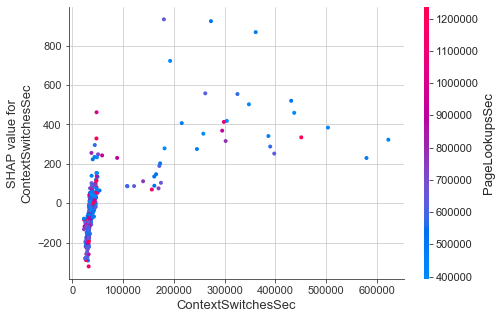

printing feature: PageLifeExpectancySec against ContextSwitchesSec


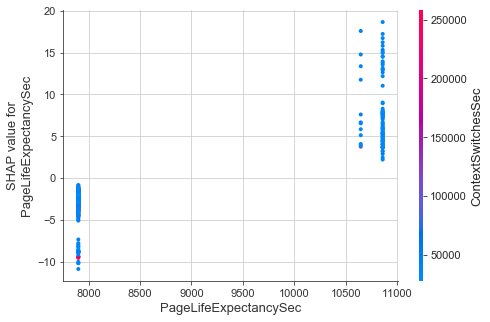

printing feature: PageLifeExpectancySec against IndexSearches


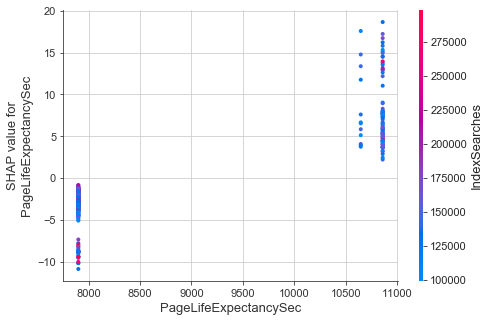

printing feature: PageLifeExpectancySec against PageLookupsSec


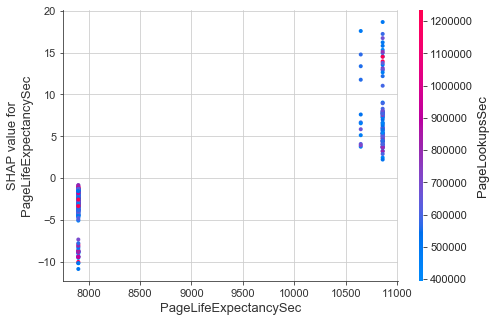

printing feature: IndexSearches against ContextSwitchesSec


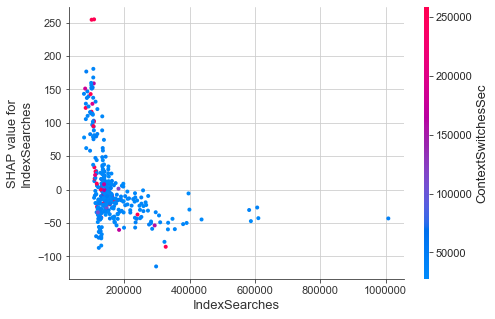

printing feature: IndexSearches against PageLifeExpectancySec


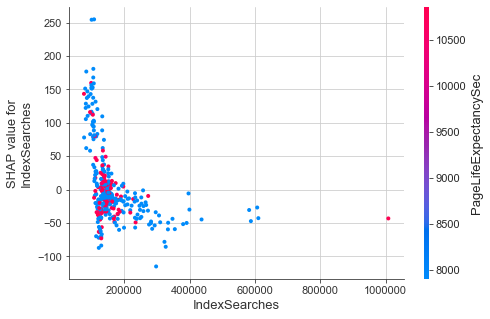

printing feature: IndexSearches against PageLookupsSec


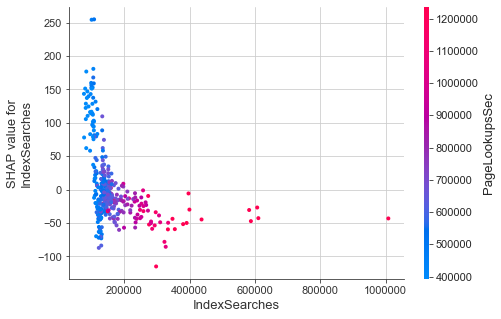

printing feature: PageLookupsSec against ContextSwitchesSec


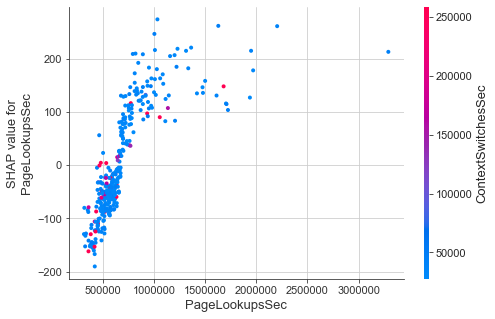

printing feature: PageLookupsSec against PageLifeExpectancySec


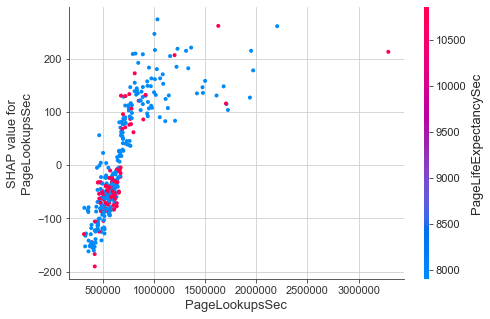

printing feature: PageLookupsSec against IndexSearches


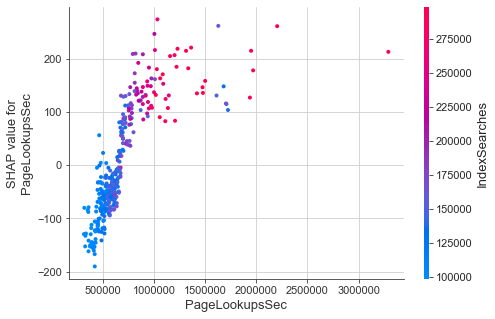

In [15]:
t copy 

for name in columns: 
    interaction_columns = copy.deepcopy(columns)
    interaction_columns.remove(name)
    for interaction_feature in interaction_columns:
        print('printing feature: ' + str(name) + ' against ' + str(interaction_feature))
        #display_features maps our original values to the plots 
        fig = shap.dependence_plot(
                                    ind = name, shap_values = shap_values,
                                    features = X, display_features=X, 
                                    interaction_index=interaction_feature
                                    )
        #plt.savefig('dependance_plot_' + name + '_vs_' + interaction_feature +'.png')    
